In [ ]:
#| hide
#skip
! [ -e /content ] && pip install -Uqq pyndamics3 emcee # upgrade pyndamics3 on colab

In [ ]:
%matplotlib inline
from pylab import *
from sie.core import *

In [ ]:
def plot_distribution(dist,label=r'\bar{x}',fill_left=None,xlim=None):
    import pylab as py
    qmin=.0001
    qmax=1-qmin

    if xlim is None:
        xmin=dist.D.ppf(qmin)
        xmax=dist.D.ppf(qmax)
    else:
        xmin,xmax=xlim

    x=linspace(xmin,xmax,200)
    y=dist.D.pdf(x)

    figure(figsize=(16,5))

    plot(x,y)

    v=dist.D.ppf([2.5/100,50/100,97.5/100])
    label=label
    py.title(r'$\hat{%s}^{97.5}_{2.5}=%.3f^{%.3f}_{%.3f}$' % (label,v[1],v[2],v[0]))
    py.ylabel(r'$p(%s|{\rm true\,\, value})$' % label)
    py.xlabel(r'$%s$' % label)

    if fill_left:
        x1=x.min()
        x2=fill_left
        xf=linspace(x1,x2,100)
        yf=dist.D.pdf(xf)
        fill_between(xf,yf,facecolor='red', alpha=0.2)   
        plot(xf,yf,'r-')    
        text(x.min(),0.2,'area = %.4f' % dist.D.cdf(x2))

In [ ]:
from sie.mcmc import StatsModel

From my talk, slides available here:  https://bblais.github.io/posts/2022/Nov/08/one-rule-to-rule-them-all/

## True value with known noise

- Data: $\{x_i\}=\{12,14,16\}, \sigma=1$
- Question: Is the true (population) value , $\mu$ , less than 13?

### Frequentist Approach

Uses a z-test.

In [ ]:
from sie.distributions import Normal

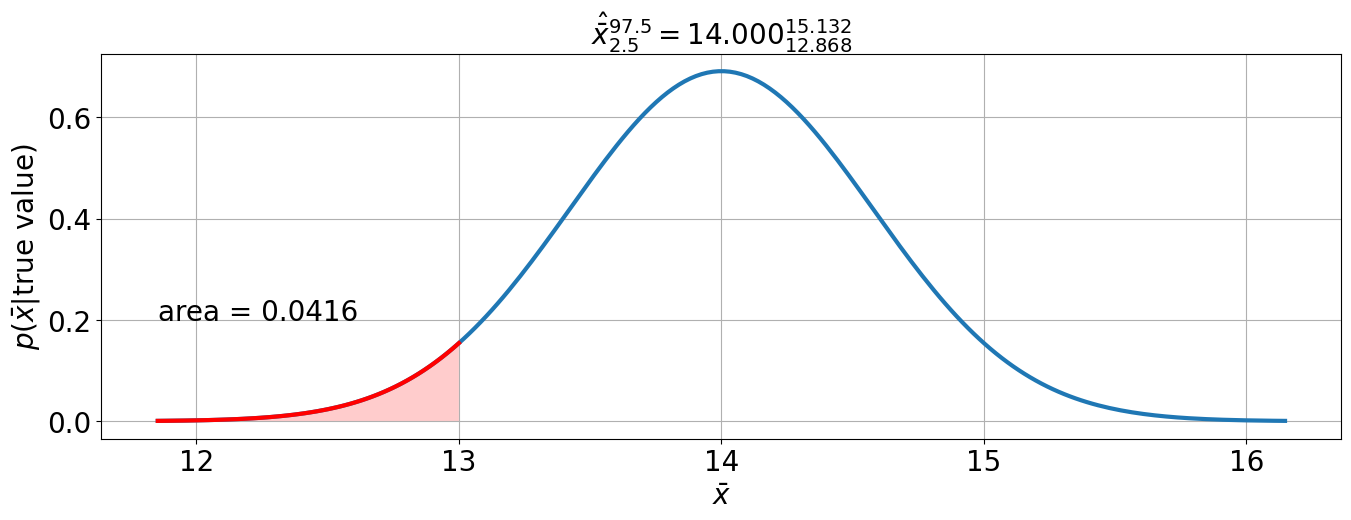

In [ ]:
x=[12,14,16]
σ=1
N=len(x)
dist=Normal(mean=mean(x),std=σ/sqrt(N))

plot_distribution(dist,fill_left=13)

### Bayesian Approach

In [ ]:
x=array([12,14,16])
model=StatsModel()
model.add_data(x=x)
model.add("μ ~ Normal(0,50)")  # really broad prior
model.add("x ~ Normal(μ,1)")


Sampling Prior...
Done.
0.18 s
Running MCMC...
Done.
1.26 s


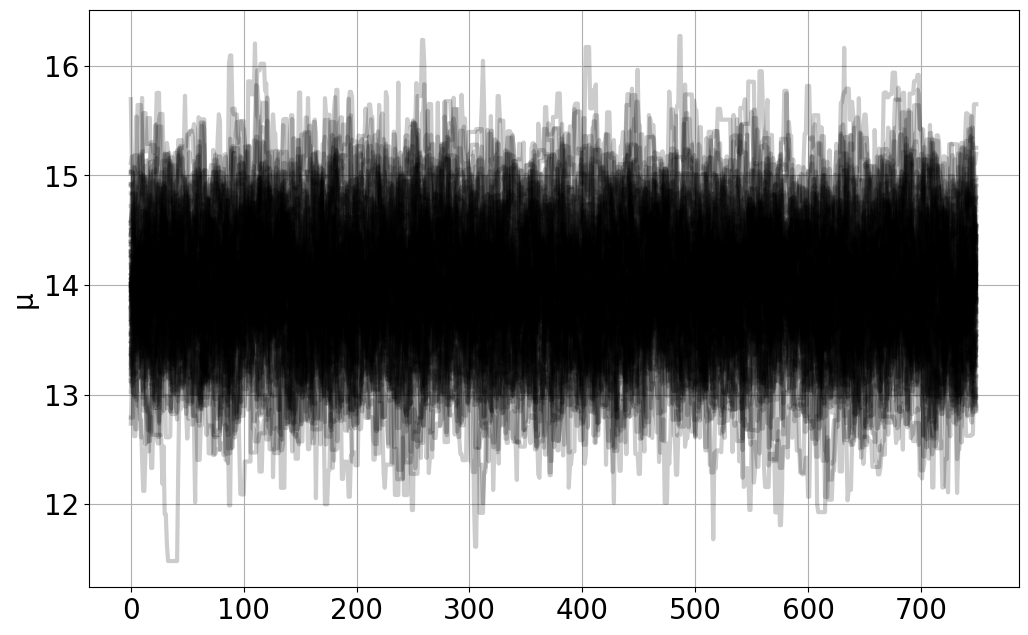

In [ ]:
model.run_mcmc(1000)
model.plot_chains()  # this is for debugging/making sure things are working

Text(11.5, 0.4, 'P(μ<13)=0.0428')

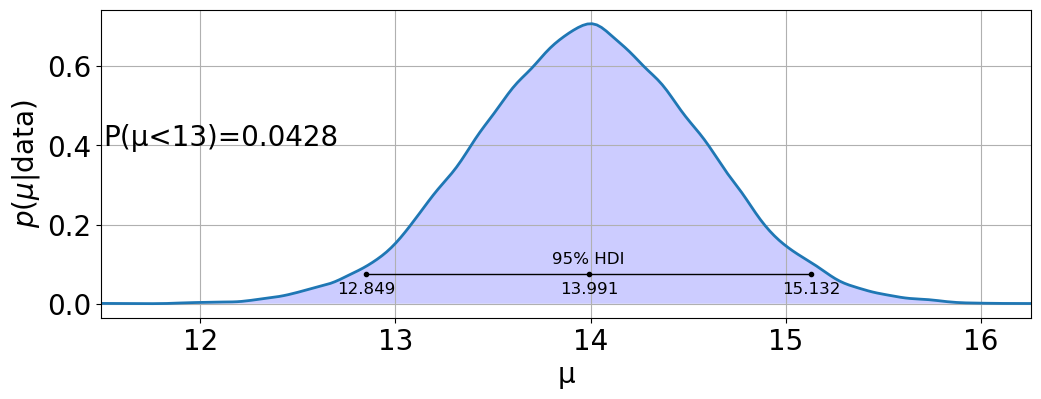

In [ ]:
model.plot_distributions()
text(11.5,.4,f"P(μ<13)={model.P('μ<13'):.3}")

In [ ]:
model.P("μ<13")

0.03881333333333333

## True value with unknown noise

- Data: $\{x_i\}=\{12,14,16\}$
- Question: Is the true (population) value , $\mu$ , less than 13?

### Frequentist Approach

Uses a Student-T test.

In [ ]:
from sie.distributions import StudentT

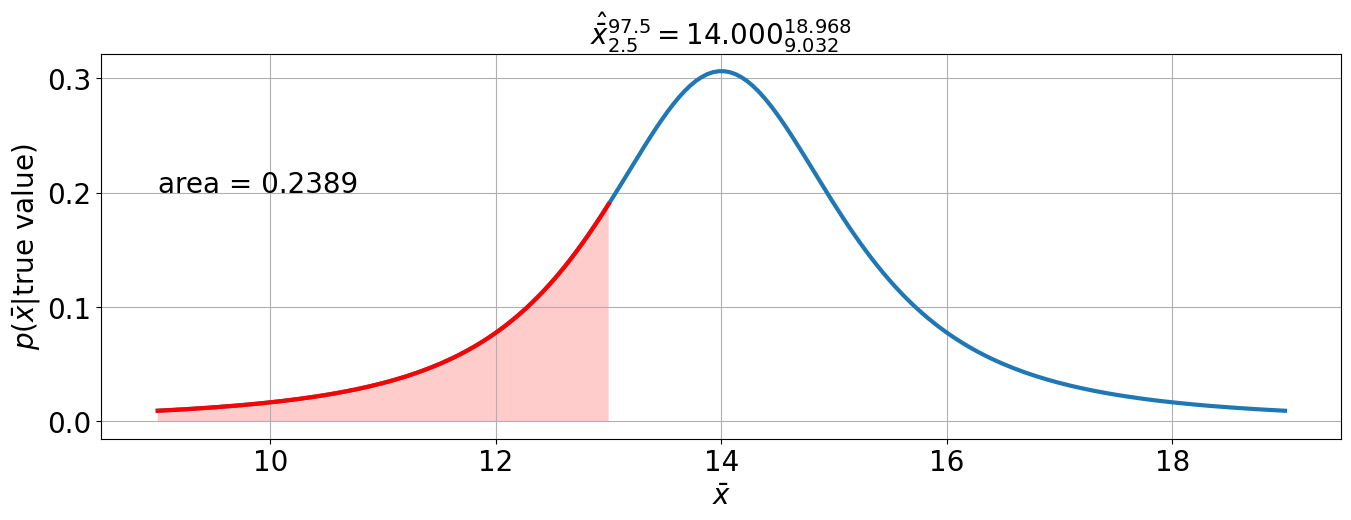

In [ ]:
x=[12,14,16]
dof=len(x)

dist=StudentT(mean=mean(x),
              std=std(x)/sqrt(N-1),
              dof=N-1)

plot_distribution(dist,fill_left=13,xlim=[9,19])

### Bayesian Approach

In [ ]:
x=array([12,14,16])
model=StatsModel()
model.add_data(x=x)
model.add("μ ~ Uniform(-50,50)")  # really broad prior
model.add("σ ~ Jeffreys()")
model.add("x ~ Normal(μ,σ)")


In [ ]:
model.run_mcmc(2000,repeat=2)
#model.plot_chains()

Sampling Prior...
Done.
0.12 s
Running MCMC 1/2...
Done.
2.31 s
Samples
Running MCMC 2/2...
Done.
2.49 s
Samples


Text(2, 0.1, 'P(μ<13)=0.242')

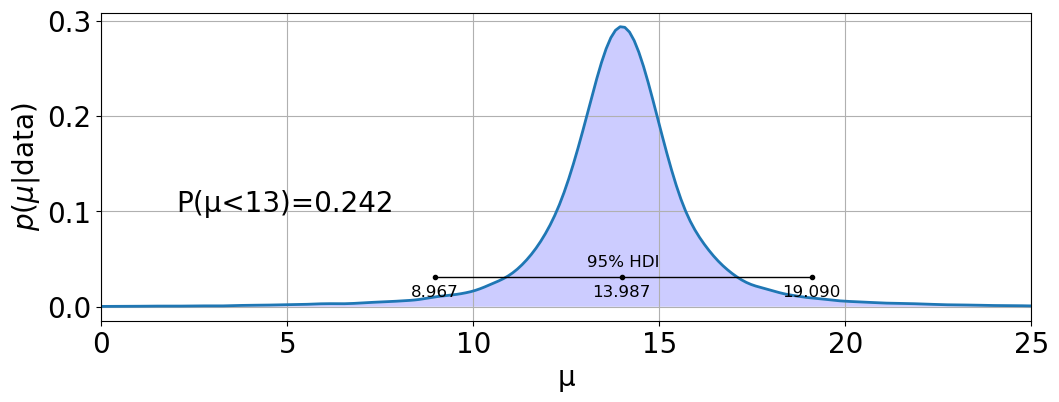

In [ ]:
model.plot_distributions('μ',xlim={'μ':[0,25],'σ':[0,30]})
text(2,.1,f"P(μ<13)={model.P('μ<13'):.3}")

and we get other comparisons for free..

Text(7.5, 0.1, 'P(σ>5)=0.154')

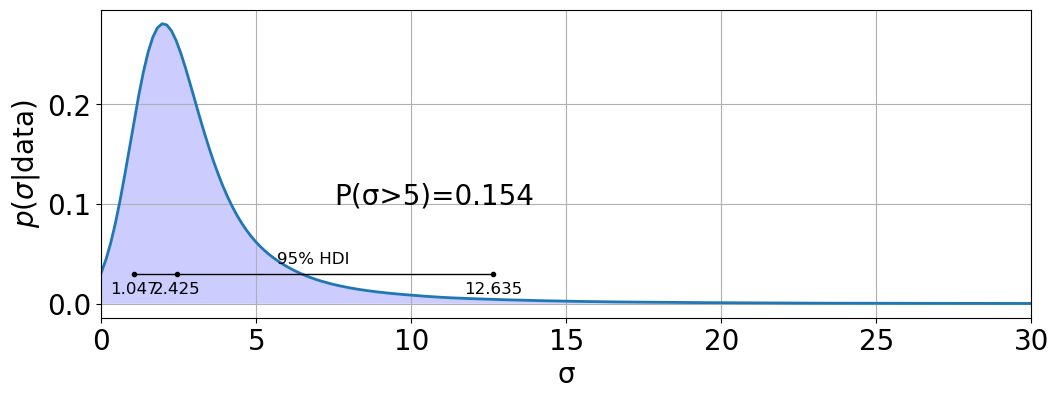

In [ ]:
model.plot_distributions('σ',xlim={'μ':[0,25],'σ':[0,30]})
text(7.5,.1,f"P(σ>5)={model.P('σ>5'):.3}")